# Image Model


In [25]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import hdbscan
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
import json
from umap import UMAP

### **Important**: If you want to use the precomputed local embeddings data (located at /embeddings), please set the variable "use_embeddings_data" to True. This will save time by skipping the recalculation of embeddings.

"use_embeddings_data" equals True will need 4 files:

- hybrid_embeddings located at /embeddings
- json_data_fact_checking located at /image_model
- json_data_fast_check_1_fixed located at /image_model
- json_data_fast_check_2_fixed located at /image_model


In [ ]:
use_embeddings_data = True

In [27]:
if not use_embeddings_data: 
    # Cargar el modelo CLIP y el procesador
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    # Función para descargar la imagen desde una URL
    def download_image(url):
        response = requests.get(url)
        image = Image.open(BytesIO(response.content)).convert("RGB")
        return image

In [28]:
def check_images(data):
    pages_checked = data
    pages_urls = []
    images_downloaded = []
    relationships = []
    index = 0

    for page in data:
        images = []
        try: 
            for image in page["images"]:
                try:
                    download = download_image(image) 
                    images_downloaded.append(download)
                    images.append(image)
                except:
                    print("No fue posible descargar la imagen. Arreglando")
                    continue
            pages_checked[index]["images"] = images
            relationships.append(len(images))
            index += 1
            pages_urls += images
        except Exception as e:
            print("error al analizar la pagina")
            print(e)
            continue 
        
    print(f"Imagenes analizadas: {len(pages_urls)}")
    pages_checked = {"pages": pages_checked, "downloaded_images": images_downloaded, "relationships": relationships}
    
    return pages_checked

In [29]:
if not use_embeddings_data: 
    # Obtiene datos del primero proceso
    json_data = {}

    with open("../../fast_check_data/test_1st.json", 'r', encoding='utf-8') as file:
        json_data = json.load(file)

    json_data_fast_check_1_fixed = check_images(json_data["pages"])

No fue posible descargar la imagen. Arreglando
No fue posible descargar la imagen. Arreglando
No fue posible descargar la imagen. Arreglando
No fue posible descargar la imagen. Arreglando
No fue posible descargar la imagen. Arreglando
Imagenes analizadas: 76


In [30]:
if not use_embeddings_data: 
    # Obtiene datos del segundo proceso
    json_data = {}

    with open("../../fast_check_data/test_2nd.json", 'r', encoding='utf-8') as file:
        json_data = json.load(file)

    json_data_fast_check_2_fixed = check_images(json_data["pages"])

No fue posible descargar la imagen. Arreglando
No fue posible descargar la imagen. Arreglando
Imagenes analizadas: 42


In [ ]:
if not use_embeddings_data: 
    # Obtiene datos de fact checking
    json_data = {}

    with open("../../fact_checking_data/fact_checking_data_extracted.json", 'r', encoding='utf-8') as file:
        json_data = json.load(file)

    json_data_fact_checking = check_images(json_data["pages"])

No fue posible descargar la imagen. Arreglando


c:\Users\usuario\Documents\UNIVERSIDAD\2024 - 2do Semestre\Capstone\Web Scraping\code\.venv\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


No fue posible descargar la imagen. Arreglando
Imagenes analizadas: 222


In [32]:
if not use_embeddings_data: 
    with torch.no_grad():
        inputs = processor(images=json_data_fast_check_1_fixed["downloaded_images"], return_tensors="pt")
        outputs = model.get_image_features(**inputs)
        image_embeddings = outputs
        torch.save(image_embeddings, '../embeddings/1st_image_embeddings.pt')

In [33]:
if not use_embeddings_data: 
    with torch.no_grad():
        inputs = processor(images=json_data_fast_check_2_fixed["downloaded_images"], return_tensors="pt")
        outputs = model.get_image_features(**inputs)
        image_embeddings = outputs
        torch.save(image_embeddings, '../embeddings/2nd_image_embeddings.pt')

In [34]:
if not use_embeddings_data: 
    with torch.no_grad():
        inputs = processor(images=json_data_fact_checking["downloaded_images"], return_tensors="pt")
        outputs = model.get_image_features(**inputs)
        image_embeddings = outputs
        torch.save(image_embeddings, '../embeddings/fact_checking_image_embeddings.pt')

In [35]:
if not use_embeddings_data: 
    json_data_fact_checking = {"pages": json_data_fact_checking["pages"]}
    json_data_fast_check_1_fixed = {"pages": json_data_fast_check_1_fixed["pages"]}
    json_data_fast_check_2_fixed = {"pages": json_data_fast_check_2_fixed["pages"]}

    with open(f"json_data_fact_checking.json", 'w', encoding='utf-8') as file:
        json.dump(json_data_fact_checking, file, ensure_ascii=False, indent=4)
    with open(f"json_data_fast_check_1_fixed.json", 'w', encoding='utf-8') as file:
        json.dump(json_data_fast_check_1_fixed, file, ensure_ascii=False, indent=4)
    with open(f"json_data_fast_check_2_fixed.json", 'w', encoding='utf-8') as file:
        json.dump(json_data_fast_check_2_fixed, file, ensure_ascii=False, indent=4)

else: 
    json_data_fact_checking = {}
    json_data_fast_check_1_fixed = {}
    json_data_fast_check_2_fixed = {}

    with open(f"json_data_fact_checking.json", 'r', encoding='utf-8') as file:
        json_data_fact_checking = json.load(file)
    with open(f"json_data_fast_check_1_fixed.json", 'r', encoding='utf-8') as file:
        json_data_fast_check_1_fixed = json.load(file)
    with open(f"json_data_fast_check_2_fixed.json", 'r', encoding='utf-8') as file:
        json_data_fast_check_2_fixed = json.load(file)

In [ ]:
#Estructura de datos para guardar las relaciones entre las imagenes y las noticias
relationships = []
image_relationships = []
for page in json_data_fast_check_1_fixed["pages"]:
    relationships.append(len(page["images"]))
    for image in page["images"]:
        image_relationships.append({"image": image, "page": page})

for page in json_data_fast_check_2_fixed["pages"]:
    relationships.append(len(page["images"]))
    for image in page["images"]:
        image_relationships.append({"image": image, "page": page})

for page in json_data_fact_checking["pages"]:
    relationships.append(len(page["images"]))
    for image in page["images"]:
        image_relationships.append({"image": image, "page": page})

#Crea una lista de cluster para luego visualizar que imagen pertenece a que noticia.
amount = 0
cluster_relationships = []
for index, relation in enumerate(relationships):
    amount += relation
    if relation == 0:
        continue
    for i in range(relation):
        cluster_relationships.append(index)

181


In [ ]:
if not use_embeddings_data: 
    image_embeddings_1st = torch.load('../embeddings/1st_image_embeddings.pt')
    image_embeddings_2nd = torch.load('../embeddings/2nd_image_embeddings.pt')
    text_embeddings_1st = torch.load('../embeddings/1st_text_embeddings.pt')
    text_embeddings_2nd = torch.load('../embeddings/2nd_text_embeddings.pt')
    image_embeddings_fact_checking = torch.load('../embeddings/fact_checking_image_embeddings.pt')
    text_embeddings_fact_checking = torch.load('../embeddings/fact_checking_text_embeddings.pt')

    #Texto
    text_embeddings_1st = torch.from_numpy(text_embeddings_1st).float() 
    text_embeddings_2nd = torch.from_numpy(text_embeddings_2nd).float() 
    text_embeddings_fact_checking = torch.from_numpy(text_embeddings_fact_checking).float() 
    hybrid_text_embeddings = torch.cat((text_embeddings_1st, text_embeddings_2nd, text_embeddings_fact_checking), dim=0)
    hybrid_text_embeddings = torch.cat(
        [hybrid_text_embeddings[i].unsqueeze(0).repeat(n, 1) for i, n in enumerate(relationships) if n != 0],
        dim=0
    )

    #Images
    hybrid_image_embeddings = torch.cat((image_embeddings_1st, image_embeddings_2nd, image_embeddings_fact_checking), dim=0)

    #Concatenación
    print(hybrid_text_embeddings.shape)
    print(hybrid_image_embeddings.shape)
    hybrid_embeddings = torch.cat((hybrid_text_embeddings, hybrid_image_embeddings), dim=1)

    #Forma Final
    print(hybrid_embeddings.shape)
    torch.save(hybrid_embeddings, '../embeddings/hybrid_embeddings.pt')

20
22
139
torch.Size([340, 768])
torch.Size([340, 512])
torch.Size([340, 1280])


C:\Users\usuario\AppData\Local\Temp\ipykernel_16460\3477074661.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_embeddings_1st = torch.load('../embeddings/1st_image

# **Important**

# If you want to use the precomputed local embeddings data (located at /embeddings), please set the variable "use_embeddings_data" to **True** at the start of this code. This will save time by avoiding the recalculation of embeddings.

# If you want to recalculate the embeddings, set the variable "use_embedding_data" to **False** at the start of this code.


In [38]:
if use_embeddings_data: 
    hybrid_embeddings = torch.load('../embeddings/hybrid_embeddings.pt')

c:\Users\usuario\Documents\UNIVERSIDAD\2024 - 2do Semestre\Capstone\Web Scraping\code\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


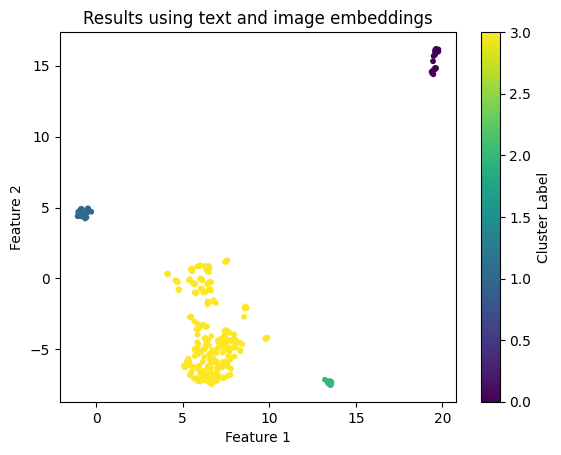

Distancia promedio: 7.696394920349121
Distancia mínima: 0.002838941290974617
Distancia máxima: 27.185792922973633
Silhouette Score: 0.6131558418273926


In [39]:
umap_model= UMAP(n_components=2, random_state=42)
embeddings_2d = umap_model.fit_transform(hybrid_embeddings)

clusterer = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=3, cluster_selection_epsilon=1.40)
cluster_labels = clusterer.fit_predict(embeddings_2d)

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='viridis', s=10)
plt.title('Results using text and image embeddings')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

distances = pairwise_distances(embeddings_2d, metric='euclidean')
average_distance = np.mean(distances)
min_distance = np.min(distances[distances > 0])
max_distance = np.max(distances)

print(f"Distancia promedio: {average_distance}")
print(f"Distancia mínima: {min_distance}")
print(f"Distancia máxima: {max_distance}")

score = silhouette_score(embeddings_2d, cluster_labels)
print(f"Silhouette Score: {score}")

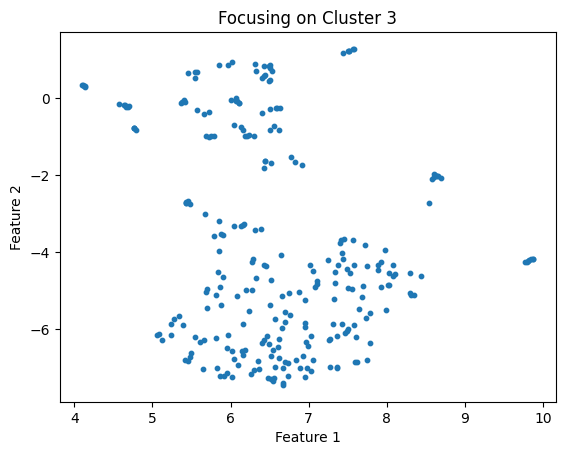

[0]   Imagen: https://www.fastcheck.cl/wp-content/uploads/2022/05/Captura-de-Pantalla-2022-05-25-a-las-09.46.00-1024x863.png
[0]   Pagina: https://www.fastcheck.cl/2022/05/25/la-palabra-indigena-esta-124-veces-en-el-borrador-de-la-nueva-constitucion-la-palabra-chileno-solo-37-veces-falso/

[1]   Imagen: https://www.fastcheck.cl/wp-content/uploads/2022/05/Captura-de-Pantalla-2022-05-25-a-las-09.56.09-1024x988.png
[1]   Pagina: https://www.fastcheck.cl/2022/05/25/la-palabra-indigena-esta-124-veces-en-el-borrador-de-la-nueva-constitucion-la-palabra-chileno-solo-37-veces-falso/

[2]   Imagen: https://www.fastcheck.cl/wp-content/uploads/2022/05/busk.png
[2]   Pagina: https://www.fastcheck.cl/2022/05/25/la-palabra-indigena-esta-124-veces-en-el-borrador-de-la-nueva-constitucion-la-palabra-chileno-solo-37-veces-falso/

[3]   Imagen: https://www.fastcheck.cl/wp-content/uploads/2022/09/image-6.png
[3]   Pagina: https://www.fastcheck.cl/2022/09/09/imagen-a-espaldas-de-la-ciudadania-cambiaron-el-a

In [45]:
hdbscan_cluster_to_print = 3
facts_selected = []
facts_labels = []

for index, fact in enumerate(embeddings_2d):
    if cluster_labels[index] == hdbscan_cluster_to_print:
        facts_selected.append(embeddings_2d[index].tolist())
        facts_labels.append(index)

plt.scatter([fact[0] for fact in facts_selected], [fact[1] for fact in facts_selected], s=10)
# for x, y, label in zip([fact[0] for fact in facts_selected], [fact[1] for fact in facts_selected], facts_labels):
#     plt.annotate(label, (x, y), textcoords="offset points", xytext=(0, 3), ha='center')
plt.title(f'Focusing on Cluster {hdbscan_cluster_to_print}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

json_data_combined = json_data_fast_check_1_fixed["pages"] + json_data_fast_check_2_fixed["pages"]
for index in facts_labels:
    print(f"[{index}]   Imagen: {image_relationships[index]['image']}")
    print(f"[{index}]   Pagina: {image_relationships[index]['page']['link']}")
    print("")


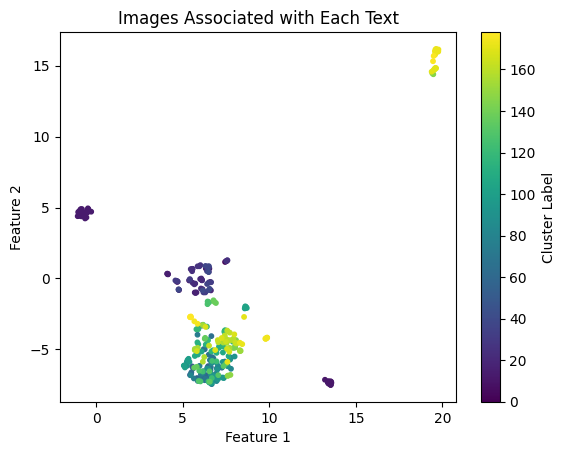

In [41]:
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_relationships, cmap='viridis', s=10)
plt.title('Images Associated with Each Text')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

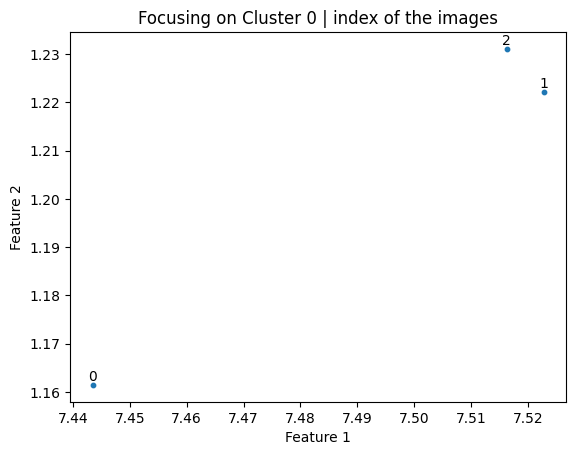

[0]   Imagen: https://www.fastcheck.cl/wp-content/uploads/2022/05/Captura-de-Pantalla-2022-05-25-a-las-09.46.00-1024x863.png
[0]   Pagina: https://www.fastcheck.cl/2022/05/25/la-palabra-indigena-esta-124-veces-en-el-borrador-de-la-nueva-constitucion-la-palabra-chileno-solo-37-veces-falso/

[1]   Imagen: https://www.fastcheck.cl/wp-content/uploads/2022/05/Captura-de-Pantalla-2022-05-25-a-las-09.56.09-1024x988.png
[1]   Pagina: https://www.fastcheck.cl/2022/05/25/la-palabra-indigena-esta-124-veces-en-el-borrador-de-la-nueva-constitucion-la-palabra-chileno-solo-37-veces-falso/

[2]   Imagen: https://www.fastcheck.cl/wp-content/uploads/2022/05/busk.png
[2]   Pagina: https://www.fastcheck.cl/2022/05/25/la-palabra-indigena-esta-124-veces-en-el-borrador-de-la-nueva-constitucion-la-palabra-chileno-solo-37-veces-falso/



In [49]:
cluster_to_print = 0

json_data_combined = json_data_fast_check_1_fixed["pages"] + json_data_fast_check_2_fixed["pages"]

facts_selected = []
facts_labels = []

for index, fact in enumerate(embeddings_2d):
    if cluster_relationships[index] == cluster_to_print:
        facts_selected.append(embeddings_2d[index].tolist())
        facts_labels.append(index)

labels = []
labels_index = []
labels_relation = []

for index, image in enumerate(image_relationships):
    if index in facts_labels:
        labels_relation.append(image["page"]["veracity"])
        if image["page"]["veracity"] not in labels:
            labels.append(image["page"]["veracity"])
        labels_index.append(labels.index(image["page"]["veracity"]))

plt.scatter([fact[0] for fact in facts_selected], [fact[1] for fact in facts_selected], s=10)

for x, y, etiqueta in zip([fact[0] for fact in facts_selected], [fact[1] for fact in facts_selected], facts_labels):
    plt.annotate(etiqueta, (x, y), textcoords="offset points", xytext=(0, 3), ha='center')

plt.title(f'Focusing on Cluster {cluster_to_print} | index of the images')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

for index in facts_labels:
    print(f"[{index}]   Imagen: {image_relationships[index]['image']}")
    print(f"[{index}]   Pagina: {image_relationships[index]['page']['link']}")
    print("")

['Falso', 'Engañoso', 'Impreciso', 'Real', 'Verdadero', 'Se puso creativ@', 'Creíble', 'No es creíble', 'Sería creíble, pero...', 'Ciencia Ficción', 'Creíble, pero...']
['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'black', 'pink', 'brown', 'gray', 'cyan']


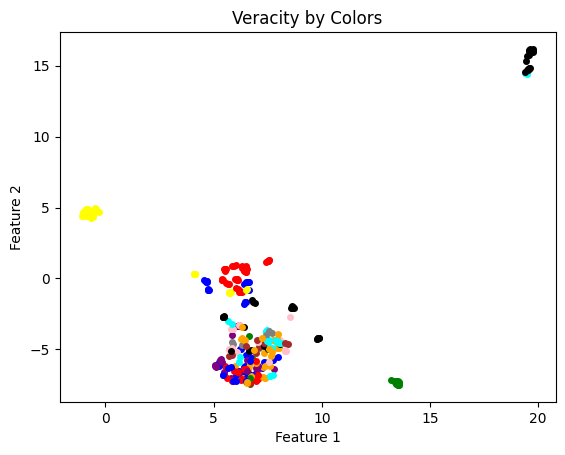

In [43]:
labels = []
labels_index = []
labels_relation = []
colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'black', 'pink', 'brown', 'gray', 'cyan']

for image in image_relationships:
    labels_relation.append(image["page"]["veracity"])
    if image["page"]["veracity"] not in labels:
        labels.append(image["page"]["veracity"])
    labels_index.append(labels.index(image["page"]["veracity"]))

print(labels)
print(colors)

for i in range(len(embeddings_2d)):
    color = colors[labels.index(labels_relation[i])]
    plt.plot(embeddings_2d[:, 0][i], embeddings_2d[:, 1][i], marker='o', linestyle='', label=labels_relation[i], ms=4, color=color) 

plt.title('Veracity by Colors')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()